In [1]:
from IPython.display import display, HTML

display(
    HTML("""
<style>
div.container{width:80% !important;}
div.prompt {min-width:70px;}
div#toc-header{margin-top:150px;}
span.toc-item-num{display:none;}
div.CodeMirror {font-family:Consolas}
div.input {font-family:Consolas}
</style>
"""))

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split  # 훈련데이터셋과 테스트데이터셋을 분리
from tensorflow.keras.models import Sequential        # 모델 생성
from tensorflow.keras.layers import Dense, Dropout    # Dense : 모델 레이어 쌓기, Dropout : 과적합 줄이기
from tensorflow.keras import metrics                  # 성능지표들
import matplotlib.pyplot as plt

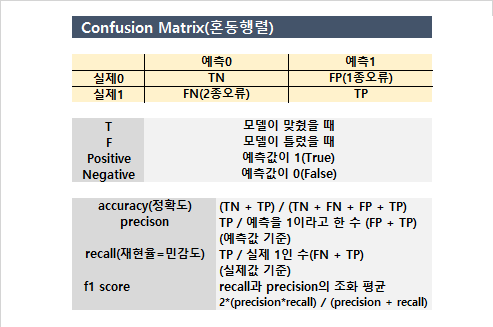

- 심장병 발병 예측
1. 데이터 셋 생성 & 전처리 <br>
    엑셀데이터 -> '?'를 nan -> nan 처리 -> X, y로 분리 -> X 스케일조정 -> 훈련셋과 테스트셋으로 분리(api 이용)
2. 모델 생성 & 구성(과적합 줄이기 단계 추가)
3. 학습 과정 설정 (accuracy, precision, recall)
4. 모델 학습시키기 (훈련셋의 일부를 검증셋으로 학습)
5. 모델 평가 - 과정 살펴보기(그래프), evaluate, pd.crosstab / confusion_matrix(혼동행렬)
6. 모델 사용하기

In [3]:
#age - 나이
#sex - (1 = 남성; 0 = 여성)
#cp - 가슴 통증 유형(0, 1, 2, 3, 4)
#trestbps - 안정 혈압(병원 입원시 mm Hg)
#chol - 혈청 콜레스테롤(mg/dl)
#fbs - (공복 혈당 > 120 mg/dl)(1 = true; 0 = false)
#restecg - 안정 심전도 결과(0, 1, 2)
#thalach - 최대 심박동수
#exang - 협심증 유발 운동(1 = yes; 0 = no)
#oldpeak - 비교적 안정되기까지 운동으로 유발되는 ST depression
#slope - 최대 운동 ST segment의 기울기
#ca - 형광 투시된 주요 혈관의 수(0-3)
#thal - (3 = 보통; 6 = 해결된 결함; 7 = 해결가능한 결함)
#target - 심장병 진단(1 = true; 0 = false)

# 1. 데이터 셋 생성 & 전처리
 - 엑셀데이터 -> '?'를 nan -> nan 처리 -> X, y로 분리 -> X 스케일조정 -> 훈련셋과 테스트셋으로 분리(api 이용)

In [5]:
raw_data = pd.read_excel('./data/heart-disease.xlsx')
raw_data.head(3)

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,0,108,1,1.5,2,3,3,1
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          303 non-null    object 
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            303 non-null    object 
 12  hsl           303 non-null    object 
 13  heartDisease  303 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 33.3+ KB


In [12]:
# raw_data의 타입이 object인 열에 '?'가 있는 데이터만 추출
raw_data[(raw_data['chol'] == '?') | (raw_data['ca'] == '?') | (raw_data['hsl'] == '?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [14]:
# '?'를 결측치(np.nan)로 대체
clean_data = raw_data.replace('?', np.nan)
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          302 non-null    float64
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            299 non-null    float64
 12  hsl           301 non-null    float64
 13  heartDisease  303 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 33.3 KB


In [18]:
# clean_data에 결측치가 포함된 데이터만 추출
clean_data[clean_data.isna().any(axis=1)]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,NaN,0,2,129,1,2.6,2,2.0,7.0,1
87,53,0,3,128,216.0,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223.0,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247.0,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204.0,1,0,156,1,1.0,2,0.0,NaN,1
287,58,1,2,125,220.0,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175.0,0,0,173,0,0.0,1,NaN,3.0,0


In [20]:
# 결측치를 중위수로 대체
# 열별 중앙값 : clean_data.median()  # axis=0 생략
clean_data.fillna(value=clean_data.median())

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
0,63,1,1,145,233.0,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286.0,0,0,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,241.5,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250.0,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204.0,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264.0,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193.0,1,0,141,0,3.4,2,2.0,7.0,1
300,57,1,4,130,131.0,0,0,115,1,1.2,2,1.0,7.0,1
301,57,0,2,130,236.0,0,2,174,0,0.0,2,1.0,3.0,1


In [22]:
# 결측치가 하나라도 있는 행 제거
clean_data.dropna(how='any', inplace=True)
clean_data.isnull().sum()

age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [23]:
clean_data.head()

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
0,63,1,1,145,233.0,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286.0,0,0,108,1,1.5,2,3.0,3.0,1
3,37,1,3,130,250.0,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204.0,0,2,172,0,1.4,1,0.0,3.0,0
5,56,1,2,120,236.0,0,0,178,0,0.8,1,0.0,3.0,0


In [32]:
# 독립변수(입력변수, X), 종속변수(타겟변수, y) 분리
Input  = clean_data.iloc[:, :-1]  # 데이터프레임
Target = clean_data.iloc[:, -1:]  # 시리즈이므로 2차원으로 바꾸기
Target = clean_data.iloc[:, [-1]]
Input.shape, Target.shape

((296, 13), (296, 1))

In [37]:
# 전체 296개 데이터 중 심장병이 걸린 데이터 수(1)
Target['heartDisease'].sum()

136

In [38]:
# 심장병이 걸린 데이터 확률(accuracy)
Target['heartDisease'].mean()

0.4594594594594595

In [53]:
# unique 별 데이터 갯수
Target['heartDisease'].value_counts()

0    160
1    136
Name: heartDisease, dtype: int64

In [45]:
# scale 조정(Input 데이터만)
scaler = MinMaxScaler()
scaled_input = pd.DataFrame(scaler.fit_transform(Input))
print(Input.shape, scaled_input.shape)
scaled_input.head(2)

(296, 13) (296, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.708333,1.0,0.0,0.481132,0.244292,1.0,1.0,0.603053,0.0,0.370968,1.0,0.0,0.75
1,0.791667,1.0,1.0,0.622642,0.365297,0.0,0.0,0.282443,1.0,0.241935,0.5,1.0,0.00


In [47]:
# scaled_input(독립변수)와 Target(종속변수) => 학습셋(훈련셋, train set) : 시험셋(test set) = 7 : 3
X_train, X_test, y_train, y_test = train_test_split(scaled_input,    # 입력변수(독립변수)
                                                    Target,          # 타겟변수(종속변수)
                                                    test_size=0.3,   # 시험셋 사이즈가 지정되면 학습셋은 자동 지정
                                                    random_state=42  # random seed 값
                                                    )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((207, 13), (207, 1), (89, 13), (89, 1))

# 2. 모델 생성 & 구성(과적합 줄이기 단계 추가)

In [48]:
model = Sequential()
model.add(Dense(units=500, input_dim=13, activation='tanh'))  # 500*13+500
# 과적합을 해결하고자 dropout(파라미터값 500개를 어느 정도 퍼센트만큼 두루뭉실하게 출력) 사용
model.add(Dropout(0.1))  # 10퍼센트
model.add(Dense(units=200, activation='tanh'))  # hidden layer  # 500*200+200 = 501*200
model.add(Dropout(0.1))  # 10퍼센트
model.add(Dense(units=100, activation='tanh'))  # hidden layer  # 200*100+100 = 201*100
model.add(Dropout(0.1))  # 10퍼센트
# 출력층에서의 활성화 함수 : 이진분류(로지스틱회귀분석)에서는 'sigmoid', 원핫인코딩을 한 분류분석에서는 'softmax'
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               7000      
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               100200    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

# 3. 학습 과정 설정 (accuracy, precision, recall)

In [49]:
# 분류분석일 때, 성능평가지표
# accuracy(정확도) : 예측결과와 실제값이 동일한 건수 / 전체건수
# precision(정밀도, 민감도) : 실제가 True인데 예측도 True로 맞춘 건수 / True로 예측한 건수
# recall(재현율) : 실제가 True인데 예측도 True로 맞춘 건수 / 실제가 True인 건수
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', metrics.Recall(), metrics.Precision()])

# 4. 모델 학습시키기 (훈련셋의 일부를 검증셋으로 학습)

In [50]:
hist = model.fit(X_train, y_train,
                 epochs=100,
                 batch_size=100,
                 verbose=1,
                 validation_split=0.2)  # 훈련데이터셋의 20%를 검증데이터셋으로

Epoch 1/100
2/2 [==============================] - 1s 398ms/step - loss: 0.6644 - accuracy: 0.5515 - recall: 0.4156 - precision: 0.5246 - val_loss: 0.5604 - val_accuracy: 0.7381 - val_recall: 0.9474 - val_precision: 0.6429
Epoch 2/100
2/2 [==============================] - 0s 37ms/step - loss: 0.5575 - accuracy: 0.7394 - recall: 0.8831 - precision: 0.6667 - val_loss: 0.4506 - val_accuracy: 0.8333 - val_recall: 0.6842 - val_precision: 0.9286
Epoch 3/100
2/2 [==============================] - 0s 37ms/step - loss: 0.4782 - accuracy: 0.8061 - recall: 0.7403 - precision: 0.8261 - val_loss: 0.4058 - val_accuracy: 0.8333 - val_recall: 0.6842 - val_precision: 0.9286
Epoch 4/100
2/2 [==============================] - 0s 38ms/step - loss: 0.4489 - accuracy: 0.8121 - recall: 0.7532 - precision: 0.8286 - val_loss: 0.3843 - val_accuracy: 0.7857 - val_recall: 0.6842 - val_precision: 0.8125
Epoch 5/100
2/2 [==============================] - 0s 43ms/step - loss: 0.4451 - accuracy: 0.8000 - recall: 0.8

Epoch 38/100
2/2 [==============================] - 0s 36ms/step - loss: 0.3716 - accuracy: 0.8485 - recall: 0.7922 - precision: 0.8714 - val_loss: 0.3792 - val_accuracy: 0.8571 - val_recall: 0.7895 - val_precision: 0.8824
Epoch 39/100
2/2 [==============================] - 0s 35ms/step - loss: 0.3573 - accuracy: 0.8545 - recall: 0.8052 - precision: 0.8732 - val_loss: 0.3816 - val_accuracy: 0.8571 - val_recall: 0.7895 - val_precision: 0.8824
Epoch 40/100
2/2 [==============================] - 0s 36ms/step - loss: 0.3673 - accuracy: 0.8545 - recall: 0.8052 - precision: 0.8732 - val_loss: 0.3847 - val_accuracy: 0.8333 - val_recall: 0.7895 - val_precision: 0.8333
Epoch 41/100
2/2 [==============================] - 0s 24ms/step - loss: 0.3619 - accuracy: 0.8606 - recall: 0.8182 - precision: 0.8750 - val_loss: 0.3864 - val_accuracy: 0.8095 - val_recall: 0.7895 - val_precision: 0.7895
Epoch 42/100
2/2 [==============================] - 0s 33ms/step - loss: 0.3803 - accuracy: 0.8364 - recall:

Epoch 75/100
2/2 [==============================] - 0s 32ms/step - loss: 0.3247 - accuracy: 0.8667 - recall: 0.8571 - precision: 0.8571 - val_loss: 0.3943 - val_accuracy: 0.8571 - val_recall: 0.8421 - val_precision: 0.8421
Epoch 76/100
2/2 [==============================] - 0s 36ms/step - loss: 0.3035 - accuracy: 0.8667 - recall: 0.8312 - precision: 0.8767 - val_loss: 0.3836 - val_accuracy: 0.8810 - val_recall: 0.8421 - val_precision: 0.8889
Epoch 77/100
2/2 [==============================] - 0s 36ms/step - loss: 0.3083 - accuracy: 0.8606 - recall: 0.8052 - precision: 0.8857 - val_loss: 0.3785 - val_accuracy: 0.8810 - val_recall: 0.8421 - val_precision: 0.8889
Epoch 78/100
2/2 [==============================] - 0s 35ms/step - loss: 0.3189 - accuracy: 0.8485 - recall: 0.7922 - precision: 0.8714 - val_loss: 0.3763 - val_accuracy: 0.8810 - val_recall: 0.8421 - val_precision: 0.8889
Epoch 79/100
2/2 [==============================] - 0s 30ms/step - loss: 0.3123 - accuracy: 0.8788 - recall:

# 5. 모델 평가 
 - 과정 살펴보기(그래프), evaluate, pd.crosstab / confusion_matrix(혼동행렬)

In [51]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'recall', 'precision', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision'])

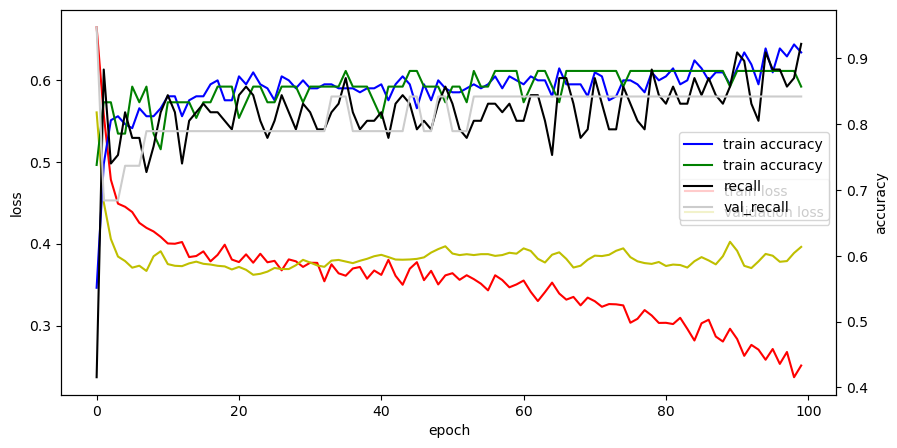

In [55]:
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['recall'], 'k', label='recall')
acc_ax.plot(hist.history['val_recall'], '#cccccc', label='val_recall')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))

plt.show()

In [58]:
# 모델 평가
score = model.evaluate(X_test, y_test)
print('model loss : ', score[0])
print('model accuracy : ', score[1])
print('model recall : ', score[2])
print('model precision : ', score[3])

3/3 [==============================] - 0s 5ms/step - loss: 0.4844 - accuracy: 0.7978 - recall: 0.8500 - precision: 0.7391
model loss :  0.4843754172325134
model accuracy :  0.7977527976036072
model recall :  0.8500000238418579
model precision :  0.739130437374115


# 6. 모델 사용하기

In [69]:
# confusion matrix (매개변수에 2차원 데이터)
y_hat = (model.predict(X_test) > 0.5).astype(int)
print('2차원 예측값 : ', y_hat.shape)  # 2차원 예측값
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
print('혼동행렬 : ', confusion_matrix(y_test, y_hat))
print('f1 score : ', f1_score(y_test, y_hat))

3/3 [==============================] - 0s 5ms/step
2차원 예측값 :  (89, 1)
혼동행렬 :  [[37 12]
 [ 6 34]]
f1 score :  0.7906976744186046


In [70]:
# crosstab (매개변수에 1차원 데이터)
pd.crosstab(y_test.values.reshape(-1),  # 1차원 실제값
            y_hat.reshape(-1))          # 예측값

col_0,0,1
row_0,,
0,37,12
1,6,34
